In [6]:
# Advanced Statistical Machine Learning & Pattern Recognition - CO495
# skeleton for CW1
# Written for Python 3.

In [7]:
import h5py
import numpy as np
import csv
import matplotlib.pyplot as plt
import scipy.cluster.vq as cluster
from matplotlib.patches import Ellipse
from scipy.io import savemat
import scipy.stats

try:
    %matplotlib inline
except NameError:
    # this is a terminal, that's fine.
    pass

In [8]:
# load the file.
f = h5py.File('X.mat')
f.keys()

X = f.get('X').value
print(np.shape(X))

(2, 2000)


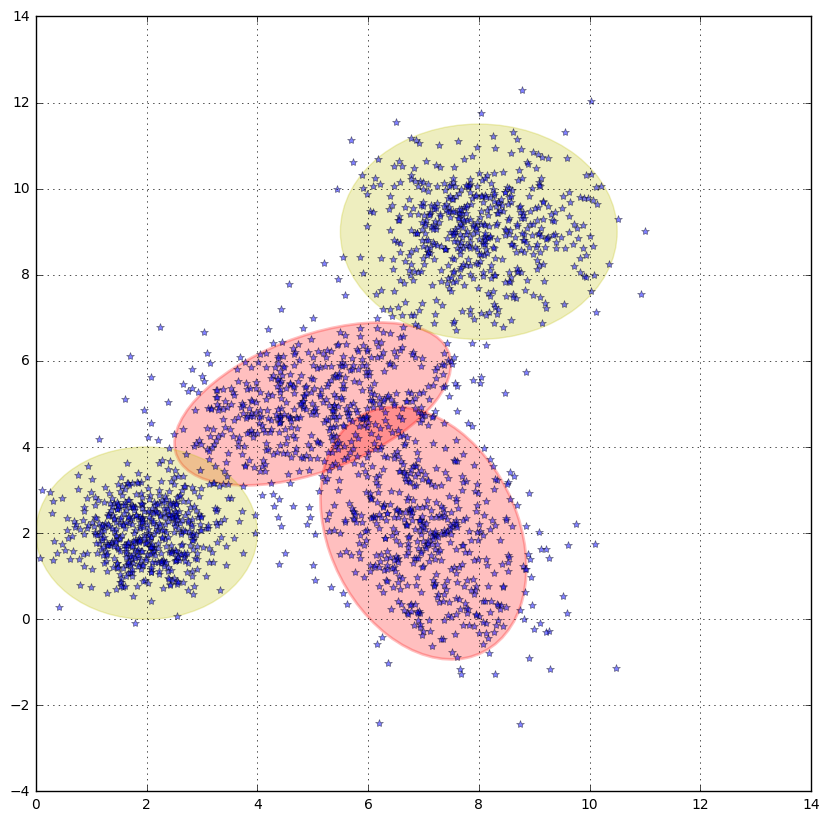

In [9]:
fig = plt.figure(figsize=(10, 10), dpi=200)
ax = plt.gca()

plt.plot(X[0, :], X[1, :], '*', alpha = 0.5, color ='b', linewidth = 0)
plt.xlim(0,14)
plt.ylim(-4,14)

circle1 = plt.Circle((2, 2), 2.0, color='y', linewidth = 1, alpha = 0.25)
circle2 = plt.Circle((8, 9), 2.5, color='y', linewidth = 1, alpha = 0.25)
ellipse1 = Ellipse(xy=(5.0, 5.0), width=3, height=5.5, angle = 300, lw=2, color ='r', alpha = 0.25)
ellipse2 = Ellipse(xy=(7.0, 2.0), width=3.5, height=6.0, angle = 375, lw=2, color ='r', alpha = 0.25)

plt.grid('on')
ax.add_artist(circle1)
ax.add_artist(circle2)
ax.add_patch(ellipse1)
ax.add_patch(ellipse2)

#ax.add_artisit(ellipse1)
#plt.axis('equal')

plt.show()


A Gaussian distribution has an isotropic covariance means its covariance is proportional to the unit covariance, $\lambda \textbf{I}$. This implies the covariance will be spherical in the variable space, which in our case (which is a 2-dimensional data), the data points should cluster and form a circle. Given that we can inferred that there are 4 Gaussians, we can group the data points into 4 different clusters in yellow and red as in the figure above via inspection.


#1 Yellow areas: For theses clusters, we can see that the data points are roughly uniformly spread around the center of the yellow regions, forming a circle. Hence, it is reasonable to infer that these 		data points have Gaussian distributions with isotropic covariance.
#2 Red areas: For these cluster, the data points are do not spread uniformly around a center. Instead, the data points have more variance in one of the dimensions. Hence, for these two clusters, we 		can infer that they have Gaussian distributions with asisotropic covariance.	
\end{itemize}

# EM Init

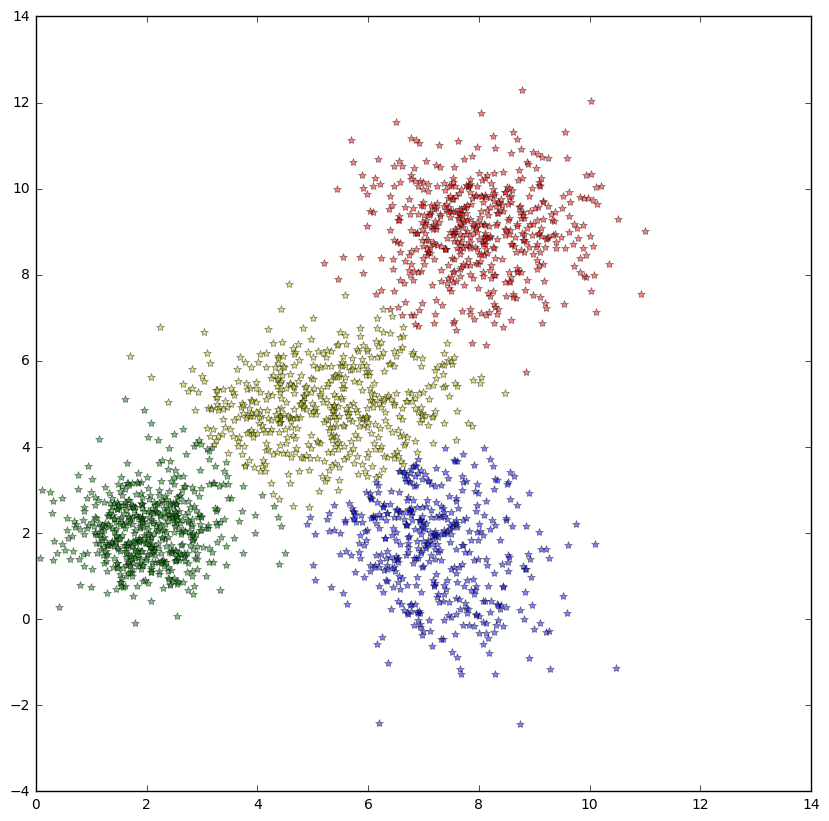

In [15]:
def EMInit(Data, nbCluster):
    
    # The K-Means 2 algorithm takes in data in data instances x features.
    # Our data is structured in features x data instances.
    Data = Data.T
    nSample =np.shape(Data)[0]
    
    X = {}
    params = {}
    for i in range(0, nbCluster):
        X[i] =[]
        params["covars_"+str(i)]= ""
        params["means_"+str(i)]= ""
        params["mixCoeff_"+str(i)] = ""
    
    # Initialization of the parameters using global mean, variance and uniform weights
    # Not to be used for final submission
    for i in range(0, nbCluster):
        params["covars_"+str(i)]= np.cov(Data.T)
        params["means_"+str(i)]= np.mean(Data.T, axis =1)
        params["mixCoeff_"+str(i)] = 1 / nbCluster   
    
    
    # Initialization of the parameters using k-means
    
    means, labels = cluster.kmeans2(Data, 4, iter=500, thresh = 1e-05, minit="random" )
    
    for i in range(0,nSample):
        X[labels[i]].append(Data[i])
       
    for i in range(0, nbCluster):
        X[i] = np.array(X[i])
        params["covars_"+str(i)]= np.cov(X[i].T)
        params["means_"+str(i)]= means[i]
        params["mixCoeff_"+str(i)] = len(X[i]) / nSample

    #print(X[1])
    
    
    fig = plt.figure(figsize=(10, 10), dpi=200)
    ax = plt.gca()

    plt.plot(X[0][:, 0], X[0][:, 1], '*', alpha = 0.5, color ='b', linewidth = 0)
    plt.plot(X[1][:, 0], X[1][:, 1], '*', alpha = 0.5, color ='r', linewidth = 0)
    plt.plot(X[2][:, 0], X[2][:, 1], '*', alpha = 0.5, color ='g', linewidth = 0)
    plt.plot(X[3][:, 0], X[3][:, 1], '*', alpha = 0.5, color ='y', linewidth = 0)
    plt.grid(on)
    plt.xlim(0,14)
    plt.ylim(-4,14)

    return params

params= EMInit(X, 4)

In [ ]:
def EMInitRandom(Data, nbCluster, subsampling):
    # The K-Means 2 algorithm takes in data in data instances x features.
    # Our data is structured in features x data instances.
    Data = Data.T
    nSample =np.shape(Data)[0]
    
    X = {}
    params = {}
    for i in range(0, nbCluster):
        X[i] =[]
        params["covars_"+str(i)]= ""
        params["means_"+str(i)]= ""
        params["mixCoeff_"+str(i)] = ""
    
    # Initialization of the parameters using global mean, variance and uniform weights
    # Not to be used for final submission
    for i in range(0, nbCluster):
        indices = np.random.choice(nSample,int(np.floor(subsampling*nSample)))
        DataSubsample = Data[indices, :]
        params["covars_"+str(i)]= np.cov(DataSubsample.T)
        params["means_"+str(i)]= np.mean(DataSubsample.T, axis =1)
        params["mixCoeff_"+str(i)] = 1 / nbCluster   
    
    return params

#params= EMInitRandom(X, 4, 0.25)

# EM E step

In [ ]:
def EMEStep(Data, nbCluster, params):

    
    Data = Data.T
    nSample =np.shape(Data)[0]
    
    resp = np.zeros((nSample,nbCluster))
    
    for i in range(0, nbCluster):

        cov=params["covars_"+str(i)]
        mean=params["means_"+str(i)]
        mixCoeff = params["mixCoeff_"+str(i)]

        for j in range(0, nSample):
            normpdf = scipy.stats.multivariate_normal.pdf(Data[j], mean,cov)
            resp[j][i] = normpdf

    marginal = np.reshape(np.array(np.sum(resp, axis=1)).T, (nSample,1))
    marginal = np.matmul(marginal,np.ones((1,nbCluster)))
    resp = np.divide(resp,marginal)
    
    return resp

resp = EMEStep(X,4,params)

# EM M step

In [ ]:
def EMMStep(Data, nbCluster, resp):
    
    Data = Data.T
    nSample =np.shape(Data)[0]

    X = {}
    params = {}
    Nk =np.sum(resp, axis=0)
    
    #print(np.multiply(np.ones(np.shape(Data)), np.reshape(resp[:,1], (nSample,1)), ))    

    for i in range(0, nbCluster):
        X[i] =[]
        
        params["means_"+str(i)]= np.matmul(Data.T, resp[:,i])/Nk[i]
        DataCentral = Data - np.ones(np.shape(Data))*params["means_"+str(i)]
        WeightedDataCentral = DataCentral*np.reshape(resp[:,i], (nSample,1))
        params["mixCoeff_"+str(i)] = Nk[i]/nSample
        params["covars_"+str(i)]= np.matmul(DataCentral.T, WeightedDataCentral) / Nk[i]

    return params



# GMM Demo

In [ ]:
# aux functions
def random_params_generator(K):
    params = {}
    for i in range(0, K):
        nn = 'means_{}'.format(i)
        params[nn] = np.random.rand(2)
        nn = 'covars_{}'.format(i)
        params[nn] = np.random.rand(2, 2)
        nn = 'mixCoeff_{}'.format(i)
        params[nn] = np.random.rand(1)
    return params


def convert_params_to_row(params, K):
    # accepts the params dict and converts it to a row to be exported.
    # The covars are flattened per row.
    row = []
    for var in ['means', 'covars', 'mixCoeff']:
        for i in range(1, K + 1):
            elems = params['{}_{}'.format(var, i-1)].flatten()
            row += [str(el) for el in elems]
    return row

In [ ]:
def GMMDemo(X, K=4):
    # accepts a 2 dimensional matrix X with the observed 
    # data and the K, which represents the number of clusters.
    # Please do not modify it!
    #
    # initialise the parameters
    params = EMInit(X, K)
    #params = EMInitRandom(X, K, 0.25)
    # params = random_params_generator(K)
    # params should be a dict() with the following format:
    # params['means_[i]'] -> [2x1 float] (i \in [1, K])
    # params['covars_[i]'] -> [2x2 float] (i \in [1, K])
    # params['mixCoeff_[i]'] -> [1x1 float] (i \in [1, K])
    
    # EM algorithm
    # do not change the iterations --- keep them fixed.
    for i  in range(10):
        # E step
        resp = EMEStep(X, K, params); # compute responsibilities, i.e., every \gamma(z_{n,k})

        # M step
        params = EMMStep(X, K, resp) # update the values for the parameters

    # comment out the line below once you have implemented 
    # the init code!
    #params = random_params_generator(K)
    # save the final values for the parameters
    # savemat('params.mat', {'params' : params})
    # export in csv.    
    # print(params)
    row = convert_params_to_row(params, K)
    with open('params.csv', 'w', encoding='utf-8-sig') as fn:
        writer = csv.writer(fn)
        writer.writerow(row)

In [ ]:
GMMDemo(X)